In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import timeit
from time import sleep
import cv2.aruco as aruco
import math
from IPython.display import display, clear_output
import math, sys, os
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

In [2]:
import time

In [3]:
from global_utils import convert_to_np,sort_coords,vis_graph,heuristic,a_star,plot_map,swap_xy
from vision_utils import *

In [4]:
#setup camera
cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_EXPOSURE, -4)  #adjust this to avoid reflection from A4 paper

aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250) #import Arcuo Dictionary
parameters =  aruco.DetectorParameters_create()
ext_pixels = 40 #how much to dilate
TH_Poly=0.025 #threshold for Polyfit
camera_matrix = np.array([[1007.8578, 0., 627.9454], [0., 1010.2664, 326.2529], [0., 0., 1.]], dtype=np.float32)
distortion = np.array([1.21870288e-01, -7.16272780e-01, -7.01033059e-03, -3.83577419e-04, 9.43910859e-01], dtype=np.float32)

In [7]:
# red_lower = np.array([140, 120, 150])
# red_upper = np.array([185, 180, 210])
red_lower = np.array([140, 90, 200])
red_upper = np.array([185, 160, 255])
## This is for testing with still image. when using, import from utils
def localisation_cam(frame):
    '''take camera instance as input, return if camera is ok, current Thymio pose, current obstacle map'''
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, _ = aruco.detectMarkers(gray,aruco_dict,parameters=parameters)
    corner_points = []  
    #marker1=topleft   marker2=topright marker3=bottomleft marker4=bottomright
    Thymio_center=[-1,-1]
    Thymio_target=[-1,-1]
    Thymio_dir = -1
    cam_OK = True
#     try:
    for i in range(1,5):  
        corner_points.append(corners[ids.tolist().index([i])][0][0].tolist())
    pts1 = np.float32(corner_points)
    pts2 = np.float32([[0, 0], [1280, 0], [0, 720], [1280, 720]])
    transform = cv2.getPerspectiveTransform(pts1, pts2)
    warpedimg = cv2.warpPerspective(frame, transform, (1280, 720))
    corners, ids, _ = aruco.detectMarkers(warpedimg,aruco_dict,parameters=parameters)
    Thymio_corner = corners[ids.tolist().index([0])]
    rvec, tvec, _ = aruco.estimatePoseSingleMarkers(Thymio_corner, 0.05, camera_matrix, distortion)
    Thymio_dir = -rotationMatrixToEulerAngles(rvec[0])[2]+180
    Thymio_center = np.mean(Thymio_corner, axis=1).tolist()[0]
    Thymio_center = [int(Thymio_center[0]),int(Thymio_center[1])]
    Thymio_center.reverse()
    Thymio_target = np.mean(corners[ids.tolist().index([5])], axis=1).tolist()[0]
    Thymio_target = [int(Thymio_target[0]),int(Thymio_target[1])]
    Thymio_target.reverse()
    HSV = cv2.cvtColor(warpedimg, cv2.COLOR_RGB2HSV)
    HSV_blur = cv2.GaussianBlur(HSV, (7, 7), 0)
    red_mask=cv2.inRange(HSV_blur,red_lower,red_upper)
    red_mask_closed = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8),iterations=2)
    obstacles_mask = cv2.dilate(red_mask_closed, np.ones((int(ext_pixels*2-1),int(ext_pixels*2-1)), np.uint8), iterations=1)
    obs_corners = []
    contours, hierarchy = cv2.findContours(obstacles_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    obstacles_mask[obstacles_mask==255]=1
    for cnt in contours:
        if cv2.contourArea(cnt) > 1000:#drop spots
            temp = []
            epsilon = TH_Poly*cv2.arcLength(cnt,True)
            approx = cv2.approxPolyDP(cnt,epsilon,True)
            for point in approx:
                point_original = list(point[0])
                temp.append([point_original[1],point_original[0]])
            obs_corners.append(temp)
#     except:
#         cam_OK=False

    img_out=np.ones((HSV_blur.shape[0],HSV_blur.shape[1],3),np.uint8)*255
    _, mask = cv2.threshold(red_mask, thresh=180, maxval=255, type=cv2.THRESH_BINARY)
    img_out[mask==255] = [200,20,20]
    thymio_icon = cv2.imread('Thymio.jpg')
    thymio_icon = cv2.cvtColor(thymio_icon, cv2.COLOR_RGB2BGR)
    warpedimg_clean = merge_img(img_out, rotate_image(thymio_icon,Thymio_dir), int(Thymio_center[0])-120, int(Thymio_center[0])+120, int(Thymio_center[1])-120, int(Thymio_center[1])+120)
    return cam_OK, Thymio_center, Thymio_dir, Thymio_target, obs_corners, obstacles_mask, warpedimg, warpedimg_clean[:,:,0:3]

In [15]:
cam_OK, Thymio_start, Thymio_dir, Thymio_target, obs_corners, obstacles_mask, img_out = localisation_cam_all(frame)

In [10]:
red_lower = np.array([140, 90, 180])
red_upper = np.array([185, 160, 255])
# red_lower = np.array([140, 120, 150])
# red_upper = np.array([180, 180, 210])
# ret, frame = cap.read()
# while(not ret):
#     cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
#     cap.set(cv2.CAP_PROP_EXPOSURE, -4)
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
corners, ids, _ = aruco.detectMarkers(gray,aruco_dict,parameters=parameters)
corner_points = []  
#marker1=topleft   marker2=topright marker3=bottomleft marker4=bottomright
Thymio_start=[-1,-1]
Thymio_target=[-1,-1]
Thymio_dir = -1
obs_corners = []
obstacles_mask=[]
warpedimg_clean =[]
warpedimg=[]
img_out=np.ones((720,1280,3),np.uint8)*255
cam_OK = True
for i in range(1,5):  
    corner_points.append(corners[ids.tolist().index([i])][0][0].tolist())
pts1 = np.float32(corner_points)
pts2 = np.float32([[0, 0], [1280, 0], [0, 720], [1280, 720]])
transform = cv2.getPerspectiveTransform(pts1, pts2)
warpedimg = cv2.warpPerspective(frame, transform, (1280, 720))
corners, ids, _ = aruco.detectMarkers(warpedimg,aruco_dict,parameters=parameters)
Thymio_corner = corners[ids.tolist().index([0])]
rvec, tvec, _ = aruco.estimatePoseSingleMarkers(Thymio_corner, 0.05, camera_matrix, distortion)
Thymio_dir = -rotationMatrixToEulerAngles(rvec[0])[2]+180
Thymio_center = np.mean(Thymio_corner, axis=1).tolist()[0]
# Thymio_center = [int(Thymio_center[0]),int(Thymio_center[1])]
Thymio_center.reverse()
Thymio_target = np.mean(corners[ids.tolist().index([5])], axis=1).tolist()[0]
# Thymio_target = [int(Thymio_target[0]),int(Thymio_target[1])]
Thymio_target.reverse()
HSV = cv2.cvtColor(warpedimg, cv2.COLOR_RGB2HSV)
HSV_blur = cv2.GaussianBlur(HSV, (7, 7), 0)
red_mask=cv2.inRange(HSV_blur,red_lower,red_upper)
red_mask_closed = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8),iterations=2)
obstacles_mask = cv2.dilate(red_mask_closed, np.ones((int(ext_pixels*2-1),int(ext_pixels*2-1)), np.uint8), iterations=1)

contours, hierarchy = cv2.findContours(obstacles_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
obstacles_mask[obstacles_mask==255]=1
for cnt in contours:
    if cv2.contourArea(cnt) > 1000:#drop spots
        temp = []
        epsilon = TH_Poly*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)
        for point in approx:
            point_original = list(point[0])
            temp.append([point_original[1],point_original[0]])
        obs_corners.append(temp)



_, mask = cv2.threshold(red_mask, thresh=180, maxval=255, type=cv2.THRESH_BINARY)
img_out[mask==255] = [200,20,20]
Thymio_start = Thymio_center

In [9]:
img_out[mask==255]

array([255., 255., 255., ..., 255., 255., 255.])

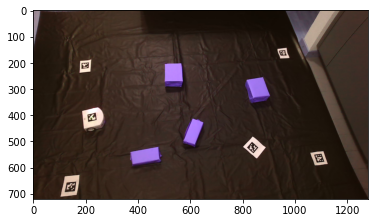

In [6]:
frame = cv2.imread('test3.png')
# frame = cv2.imread('test_im_floor.jpeg')
plt.imshow(frame)

In [6]:
cam_OK, Thymio_center, Thymio_dir, Thymio_target, obs_corners, obstacles_mask, warpedimg, warpedimg_clean = localisation_cam(frame)

NameError: name 'frame' is not defined

In [8]:
#run one time or when replanning
[obs_coords, start, goal] = convert_to_np(obs_corners, Thymio_center, Thymio_target)
obs_coords = sort_coords(obs_coords)
[nodes, edges] = vis_graph(obs_coords, start, goal)
h = heuristic(nodes)
optimal_path = a_star(nodes, edges, h)

In [14]:
warpedimg_clean_annotated = overlay_vis_graph(Thymio_center, Thymio_target, obs_corners, optimal_path, warpedimg_clean)
warpedimg_annotated = overlay_vis_graph(Thymio_center, Thymio_target, obs_corners, optimal_path, warpedimg)

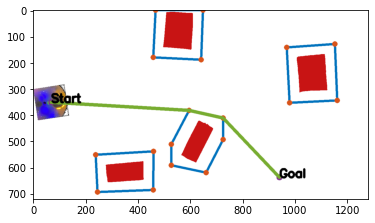

In [13]:
plt.imshow(warpedimg_clean_annotated)

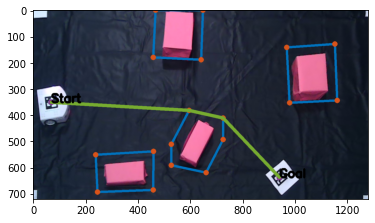

In [15]:
plt.imshow(warpedimg_annotated)

In [89]:
#119, 172, 48 217, 83, 25 ;126, 47, 142 purple

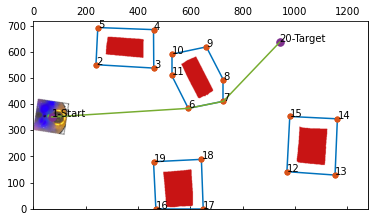

In [9]:
vis_graph = plot_map(*swap_xy(obs_coords, start, goal, edges, optimal_path),warpedimg_clean)

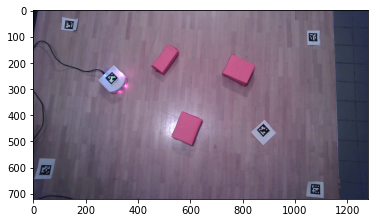

In [6]:
ret, frame = cap.read()
while(not ret):
    cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
sleep(0.01)

## Dynamic plotting

In [16]:
# %matplotlib inline
# plotting in loop. use this function in main loop, add kalman filter to axses
%matplotlib qt
fig, axs = plt.subplots(2,1,figsize=(16,18))

# plt.plot()
while True:
#     try:
        #uncomment for cap
#         ret, frame = cap.read()
#         while(not ret):
#             cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
#         frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cam_OK, Thymio_center, Thymio_dir, Thymio_target, obs_corners, obstacles_mask, warpedimg, warpedimg_clean = localisation_cam(frame)
        warpedimg_clean_annotated = overlay_vis_graph(Thymio_center, Thymio_target, obs_corners, optimal_path, warpedimg_clean)
        warpedimg_annotated = overlay_vis_graph(Thymio_center, Thymio_target, obs_corners, optimal_path, warpedimg)
        axs[0].cla()
        axs[0].imshow(warpedimg_annotated)
        axs[1].cla()
        axs[1].imshow(warpedimg_clean_annotated)
        plt.pause(0.01)
        clear_output(wait=True)
#         time.sleep(0.00000001)
#         clear_output(wait=True)
#         plt.show()
#         display(fig)
    except KeyboardInterrupt:
        break

## All things below for testing

In [ ]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_EXPOSURE, -4)  #adjust this to avoid reflection from A4 paper

In [7]:
%%time
ret, frame = cap.read()

Wall time: 0 ns


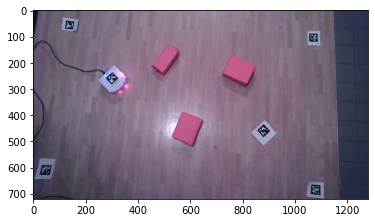

In [7]:
plt.imshow(frame)

In [8]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)

error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\imgproc\src\color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


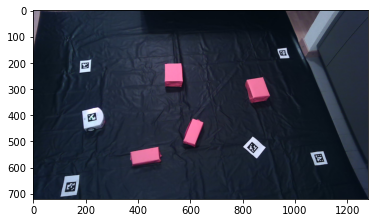

In [9]:
frame = cv2.imread('test3.png')
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
%matplotlib inline
plt.imshow(frame)

In [148]:
cv2.imwrite('test3.png',cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

True

In [11]:
corners, ids, _ = aruco.detectMarkers(gray,aruco_dict,parameters=parameters)

In [13]:
ids

array([[5],
       [2],
       [3],
       [0],
       [1]], dtype=int32)

In [8]:
%%time
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
corners, ids, _ = aruco.detectMarkers(gray,aruco_dict,parameters=parameters)
corner_points = []  
#marker1=topleft   marker2=topright marker3=bottomleft marker4=bottomright
cam_OK = True
try:
    for i in range(1,5):  
        corner_points.append(corners[ids.tolist().index([i])][0][0].tolist())
    pts1 = np.float32(corner_points)
    pts2 = np.float32([[0, 0], [1280, 0], [0, 720], [1280, 720]])
    transform = cv2.getPerspectiveTransform(pts1, pts2)
    warpedimg = cv2.warpPerspective(frame, transform, (1280, 720))
except:
    cam_OK = False
#print(corner_points)

Wall time: 12 ms


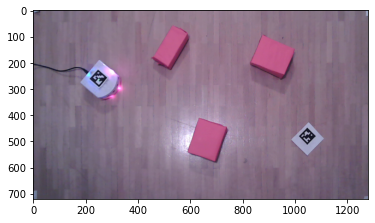

In [9]:
plt.imshow(warpedimg)

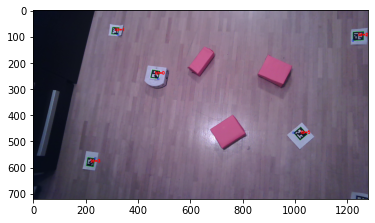

In [14]:
frame1 = frame.copy()
aruco.drawDetectedMarkers(frame1, corners,ids)
plt.imshow(frame1)
#cv2.imwrite('test4.png',cv2.cvtColor(frame1, cv2.COLOR_RGB2BGR))

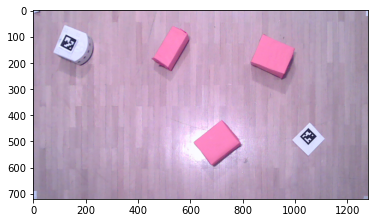

In [36]:
plt.imshow(warpedimg)
#cv2.imwrite('test5.png',cv2.cvtColor(warpedimg, cv2.COLOR_RGB2BGR))

In [37]:
corners, ids, _ = aruco.detectMarkers(warpedimg,aruco_dict,parameters=parameters)


In [38]:
corners

[array([[[1020.,  481.],
         [1052.,  450.],
         [1083.,  482.],
         [1050.,  512.]]], dtype=float32),
 array([[[104., 135.],
         [125.,  93.],
         [165., 113.],
         [145., 155.]]], dtype=float32)]

In [39]:
Thymio_corner

array([[[1057.,  564.],
        [1014.,  569.],
        [1009.,  525.],
        [1053.,  520.]]], dtype=float32)

In [11]:
%%time
try:
    corners, ids, _ = aruco.detectMarkers(warpedimg,aruco_dict,parameters=parameters)
    Thymio_corner = corners[ids.tolist().index([0])]
    rvec, tvec, _ = aruco.estimatePoseSingleMarkers(Thymio_corner, 0.05, camera_matrix, distortion)
    Thymio_dir = -rotationMatrixToEulerAngles(rvec[0])[2] + 180
    Thymio_center = np.mean(Thymio_corner, axis=1).tolist()[0]
    Thymio_center.reverse()
    Thymio_target = np.mean(corners[ids.tolist().index([5])], axis=1)
    Thymio_target.reverse()
except:
    cam_OK = False
print(f'Direction of Thymio: {Thymio_dir:0.3f} degrees, center of Thymio {Thymio_center}, center of target {Thymio_target}.')

Direction of Thymio: 51.488 degrees, center of Thymio [259.75, 249.75], center of target [[1047.75  480.25]].
Wall time: 9 ms


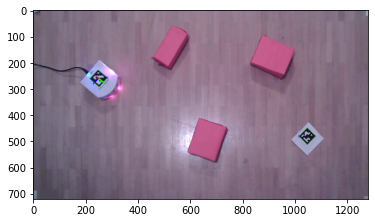

In [12]:
warpedimg2 = warpedimg.copy()
aruco.drawAxis(warpedimg2, camera_matrix, distortion, rvec[:, :], tvec[:, :], 0.03)
aruco.drawDetectedMarkers(warpedimg2, corners)
plt.imshow(warpedimg2)

In [13]:
HSV = cv2.cvtColor(warpedimg, cv2.COLOR_RGB2HSV)
HSV_blur = cv2.GaussianBlur(HSV, (7, 7), 0)

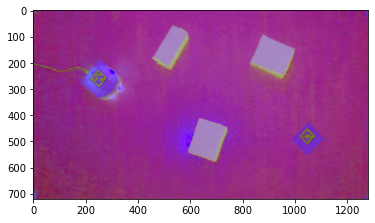

In [14]:
plt.imshow(HSV_blur)

In [18]:
def getpos(event,x,y,flags,param):
    if event==cv2.EVENT_LBUTTONDOWN:
        print(HSV_blur[y,x])
#th2=cv2.adaptiveThreshold(imagegray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
cv2.imshow("imageHSV",HSV_blur)
cv2.setMouseCallback("imageHSV",getpos)
cv2.waitKey(0)

[165 134 197]
[166 134 197]
[165 134 190]
[166 133 194]
[164 132 187]
[165 134 196]
[165 139 190]
[166 137 182]
[166 134 198]
[166 135 199]
[166 138 192]
[166 136 196]


-1

In [30]:
cam_OK

False

In [102]:
cv2.destroyAllWindows()

In [ ]:

def merge_img(map_img, thymio_img, y1, y2, x1, x2):
    '''function to overlay thymio_icon onto the graph
    jpg_img is thymio icon i'''
    if map_img.shape[2] == 3:
        map_img = add_alpha_channel(map_img)
    if thymio_img.shape[2] == 3:
        thymio_img = add_alpha_channel(thymio_img)
    yy1 = 0
    yy2 = thymio_img.shape[0]
    xx1 = 0
    xx2 = thymio_img.shape[1]
 
    if x1 < 0:
        xx1 = -x1
        x1 = 0
    if y1 < 0:
        yy1 = - y1
        y1 = 0
    if x2 > map_img.shape[1]:
        xx2 = thymio_img.shape[1] - (x2 - map_img.shape[1])
        x2 = map_img.shape[1]
    if y2 > map_img.shape[0]:
        yy2 = thymio_img.shape[0] - (y2 - map_img.shape[0])
        y2 = map_img.shape[0]
        
    alpha_thymio = thymio_img[yy1:yy2,xx1:xx2,3] / 255.0
    alpha_map = 1 - alpha_thymio
    for c in range(0,3):
        map_img[y1:y2, x1:x2, c] = ((alpha_map*map_img[y1:y2,x1:x2,c]) + (alpha_thymio*thymio_img[yy1:yy2,xx1:xx2,c]))
    return map_img

In [117]:
red_lower = np.array([140, 100, 200])
red_upper = np.array([185, 160, 255])
# red_lower = np.array([140, 120, 150])
# red_upper = np.array([185, 180, 210])

In [ ]:
red_lower_alt = np.array([0, 220, 220])
red_upper_alt = np.array([30, 255, 255])

In [186]:
thymio_icon = cv2.imread('Thymio.jpg')
thymio_icon = cv2.cvtColor(thymio_icon, cv2.COLOR_RGB2BGR)

In [12]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 0.5)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

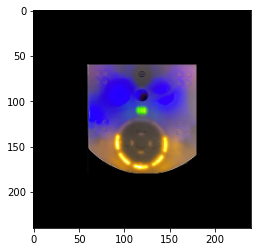

In [190]:
plt.imshow(rotate_image(thymio_icon,0))

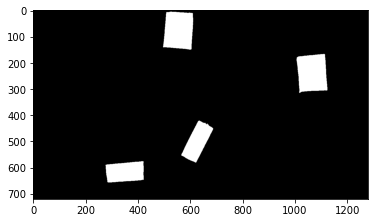

In [27]:
red_mask=cv2.inRange(HSV_blur,red_lower,red_upper)
# red_mask=cv2.inRange(HSV_blur,red_lower_alt,red_upper_alt)
plt.imshow(red_mask,cmap="gray")

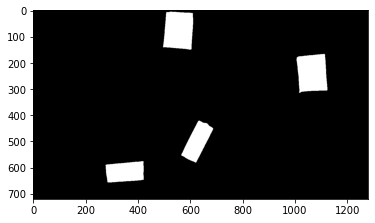

In [28]:
red_mask_closed = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8),iterations=2)
plt.imshow(red_mask_closed,cmap="gray")

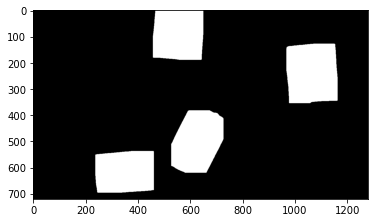

In [29]:
ext_pixels = 40 #how much to dilate
obstacles_mask = cv2.dilate(red_mask_closed, np.ones((int(ext_pixels*2-1),int(ext_pixels*2-1)), np.uint8), iterations=1)
# obstacles_mask[:1,:] = 0;
# obstacles_mask[:,:1] = 0;
# obstacles_mask[:,-1] = 0;
# obstacles_mask[-1,:] = 0;
plt.imshow(obstacles_mask,cmap="gray")

In [112]:
# warpedimg = cv2.imread('test5 - Copy.png')
# corners, ids, _ = aruco.detectMarkers(warpedimg,aruco_dict,parameters=parameters)
# Thymio_corner = corners[ids.tolist().index([0])]
# #Thymio_id = np.expand_dims(ids[ids.tolist().index([0])], axis=0)
# rvec, tvec, _ = aruco.estimatePoseSingleMarkers(Thymio_corner, 0.05, camera_matrix, distortion)
# print(-rotationMatrixToEulerAngles(rvec[0])[2])
# warpedimg2 = warpedimg.copy()
# aruco.drawAxis(warpedimg2, camera_matrix, distortion, rvec[:, :], tvec[:, :], 0.03)
# aruco.drawDetectedMarkers(warpedimg2, corners)
# plt.imshow(warpedimg2)
# warpedimg = cv2.imread('test6 - Copy.png')
# corners, ids, _ = aruco.detectMarkers(warpedimg,aruco_dict,parameters=parameters)
# Thymio_corner = corners[ids.tolist().index([0])]
# #Thymio_id = np.expand_dims(ids[ids.tolist().index([0])], axis=0)
# rvec, tvec, _ = aruco.estimatePoseSingleMarkers(Thymio_corner, 0.05, camera_matrix, distortion)
# print(-rotationMatrixToEulerAngles(rvec[0])[2])
# warpedimg2 = warpedimg.copy()
# aruco.drawAxis(warpedimg2, camera_matrix, distortion, rvec[:, :], tvec[:, :], 0.03)
# aruco.drawDetectedMarkers(warpedimg2, corners)
# plt.imshow(warpedimg2)

In [113]:
# img = cv2.imread('test_im1.png')
# img_bw = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# plt.imshow(img_bw,cmap='gray')

In [114]:
%%time
contours, hierarchy = cv2.findContours(obstacles_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

Wall time: 1 ms


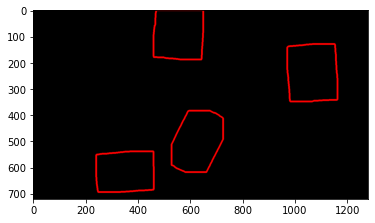

In [115]:
img_out=np.ones((obstacles_mask.shape[0],obstacles_mask.shape[1],3), np.uint8)
cv2.drawContours(img_out, contours, -1, (255, 0, 0), 5)
plt.imshow(img_out)

In [116]:
TH_Poly=0.025 #threshold for Polyfit

[[[539, 460], [550, 243], [692, 248], [684, 460]], [[383, 596], [511, 529], [590, 529], [617, 662], [492, 726], [412, 726]], [[129, 1152], [142, 971], [348, 983], [340, 1163]], [[0, 471], [179, 461], [188, 643], [0, 650]]]
Wall time: 37 ms


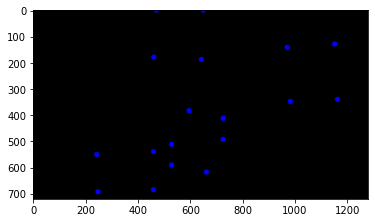

In [117]:
%%time
blank_img = np.zeros((obstacles_mask.shape[0],obstacles_mask.shape[1],3), np.uint8)
corners = []
for cnt in contours:
    if cv2.contourArea(cnt) > 1000:#drop spots
        temp = []
        epsilon = TH_Poly*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)
        for point in approx:
            cv2.circle(blank_img,tuple(point[0]),10,[0,0,255],-1)
            point_original = list(point[0])
            temp.append([point_original[1],point_original[0]])
        corners.append(temp)
plt.imshow(blank_img)
print(corners)

In [118]:
corners

[[[539, 460], [550, 243], [692, 248], [684, 460]],
 [[383, 596], [511, 529], [590, 529], [617, 662], [492, 726], [412, 726]],
 [[129, 1152], [142, 971], [348, 983], [340, 1163]],
 [[0, 471], [179, 461], [188, 643], [0, 650]]]

In [119]:
print(f'Direction of Thymio: {Thymio_dir:0.3f} degrees, center of Thymio {Thymio_center}.')

Direction of Thymio: 92.921 degrees, center of Thymio [321.5, 86.0].


In [36]:
img_out=np.ones((HSV_blur.shape[0],HSV_blur.shape[1],3),np.uint8)*255
_, mask = cv2.threshold(red_mask, thresh=180, maxval=255, type=cv2.THRESH_BINARY)
img_out[mask==255] = [200,20,20]
thymio_icon = cv2.imread('Thymio.jpg')
thymio_icon = cv2.cvtColor(thymio_icon, cv2.COLOR_RGB2BGR)
warpedimg_clean = merge_img(img_out, rotate_image(thymio_icon,Thymio_dir), int(Thymio_center[0])-120, int(Thymio_center[0])+120, int(Thymio_center[1])-120, int(Thymio_center[1])+120)
    

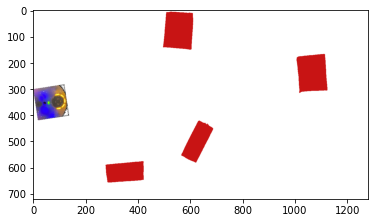

In [37]:
plt.imshow(warpedimg_clean)

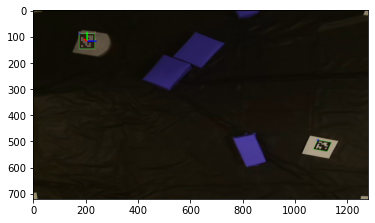

In [373]:
plt.imshow(warpedimg2)

## Function Implementation

In [3]:
#setup camera
cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_EXPOSURE, -4)  #adjust this to avoid reflection from A4 paper

aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250) #import Arcuo Dictionary
parameters =  aruco.DetectorParameters_create()
ext_pixels = 40 #how much to dilate
TH_Poly=0.025 #threshold for Polyfit

In [210]:
localisation_cam(cap)

(True,
 [350.75, 69.25],
 99.4089582505319,
 [637.25, 941.25],
 [array([[[937., 671.],
          [909., 634.],
          [946., 603.],
          [973., 641.]]], dtype=float32),
  array([[[ 89., 323.],
          [ 95., 371.],
          [ 49., 378.],
          [ 44., 331.]]], dtype=float32),
  [[538, 460], [551, 239], [693, 245], [685, 461]],
  [[382, 596], [512, 527], [592, 527], [619, 661], [492, 727], [412, 727]],
  [[129, 1153], [143, 968], [354, 978], [345, 1162]],
  [[0, 468], [181, 459], [189, 643], [0, 650]]])

In [208]:
def localisation_cam(cap):
    '''take camera instance as input, return if camera is ok, current Thymio pose, current obstacle map'''
    ret, frame = cap.read()
    while(not ret):
        cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
        cap.set(cv2.CAP_PROP_EXPOSURE, -4)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, _ = aruco.detectMarkers(gray,aruco_dict,parameters=parameters)
    corner_points = []  
    #marker1=topleft   marker2=topright marker3=bottomleft marker4=bottomright
    Thymio_center=[-1,-1]
    Thymio_target=[-1,-1]
    Thymio_dir = -1
    cam_OK = True
#     try:
    for i in range(1,5):  
        corner_points.append(corners[ids.tolist().index([i])][0][0].tolist())
    pts1 = np.float32(corner_points)
    pts2 = np.float32([[0, 0], [1280, 0], [0, 720], [1280, 720]])
    transform = cv2.getPerspectiveTransform(pts1, pts2)
    warpedimg = cv2.warpPerspective(frame, transform, (1280, 720))
    corners, ids, _ = aruco.detectMarkers(warpedimg,aruco_dict,parameters=parameters)
    Thymio_corner = corners[ids.tolist().index([0])]
    rvec, tvec, _ = aruco.estimatePoseSingleMarkers(Thymio_corner, 0.05, camera_matrix, distortion)
    Thymio_dir = -rotationMatrixToEulerAngles(rvec[0])[2]+180
    Thymio_center = np.mean(Thymio_corner, axis=1).tolist()[0]
    Thymio_center.reverse()
    Thymio_target = np.mean(corners[ids.tolist().index([5])], axis=1).tolist()[0]
    Thymio_target.reverse()
    HSV = cv2.cvtColor(warpedimg, cv2.COLOR_RGB2HSV)
    HSV_blur = cv2.GaussianBlur(HSV, (7, 7), 0)
    red_mask=cv2.inRange(HSV_blur,red_lower,red_upper)
    red_mask_closed = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8),iterations=2)
    obstacles_mask = cv2.dilate(red_mask_closed, np.ones((int(ext_pixels*2-1),int(ext_pixels*2-1)), np.uint8), iterations=1)
    obs_corners = []
    contours, hierarchy = cv2.findContours(obstacles_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    obstacles_mask[obstacles_mask==255]=1
    for cnt in contours:
        if cv2.contourArea(cnt) > 1000:#drop spots
            temp = []
            epsilon = TH_Poly*cv2.arcLength(cnt,True)
            approx = cv2.approxPolyDP(cnt,epsilon,True)
            for point in approx:
                point_original = list(point[0])
                temp.append([point_original[1],point_original[0]])
            obs_corners.append(temp)
#     except:
#         cam_OK=False

    img_out=np.ones((HSV_blur.shape[0],HSV_blur.shape[1],3),np.uint8)*255
    _, mask = cv2.threshold(red_mask, thresh=180, maxval=255, type=cv2.THRESH_BINARY)
    img_out[mask==255] = [200,20,20]
    thymio_icon = cv2.imread('Thymio.jpg')
    thymio_icon = cv2.cvtColor(thymio_icon, cv2.COLOR_RGB2BGR)
    warpedimg_clean = merge_img(img_out, rotate_image(thymio_icon,Thymio_dir), int(Thymio_center[0])-120, int(Thymio_center[0])+120, int(Thymio_center[1])-120, int(Thymio_center[1])+120)
    return cam_OK, Thymio_center, Thymio_dir, Thymio_target, obs_corners, obstacles_mask, warpedimg, warpedimg_clean